In [13]:
from pylab import *
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import *
from scipy.integrate import quad
from qutip import *
mpl.__version__

'3.1.2'

# Single qubit gate on a Qutrit

Information about the pulse can be found here
https://static-content.springer.com/esm/art%3A10.1038%2Fs41534-019-0185-4/MediaObjects/41534_2019_185_MOESM1_ESM.pdf

In [14]:
# energy levels
N = 3 # Qutrit

# Annihilation operator for the transmon
a = destroy(N)

# Qubit frequency (0->1) in MHz
omega = 2*np.pi*5.708390 * 1000

# Drive frequency in MHz
omega_drive = omega

# Self-Kerr coefficient (anharmonicity) in MHz
alpha = - 2*np.pi*261.081457

# Set rotating frame frequency (should be close to qubit frequencies for fast simulations)
rotating_frame = omega #2*np.pi*5.0 * 1000

# Transmon Hamiltonian in rotating frame
H_qubit = (omega-rotating_frame) * a.dag() * a + alpha / 2 * pow(a.dag(),2) * pow(a,2)

# Drive Hamiltonian (since we have drag pulses, we need both x and y drive)
H_drive_x = a.dag() + a
H_drive_y = 1j*(a.dag() - a)

# Gaussian width in μs
sigma = 0.010 # = 10 ns

# Gate time in μs
L = 0.050 # = 50 ns

def H_drive_coeff_x(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = q * (t-0.5*L) / sigma * E # dE/dt
    return I*np.cos(drive_freq * t) + Q*np.sin(drive_freq * t)

def H_drive_coeff_y(t, args):
    
    # Amplitude, needs to be optimized to get perfect pi pulse or pi/2 pulse
    B = args['amp']
    
    # DRAG-parameter, needs to be optimized to get no phase errors in a pi/2 pulse
    q = args['qscale']
    
    drive_freq = args['freq']
    
    # E(t)
    E = B * np.exp(-pow(t-0.5*L, 2) / (2*pow(sigma,2)))
    
    I = E
    Q = -q * (t-0.5*L) / sigma * E # dE/dt
    return Q*np.cos(drive_freq * t) + I*np.sin(drive_freq * t)

# total Hamiltonian
H = [H_qubit,
     [H_drive_x,H_drive_coeff_x],
     [H_drive_y,H_drive_coeff_y]
    ]

## Find the amplitude that corresponds to a $\pi$-pulse

In [15]:
# Total time in μs
t_total = L
tlist = np.linspace(0,t_total,500)

args = {'amp': 1, 'qscale': 0.018, 'freq': (rotating_frame - omega_drive)}

# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

# Integrate along the given time-axis using the composite trapezoidal rule
B = np.pi/(2*np.abs(np.trapz(I + 1j*Q, x=tlist)))
print(B)

63.45380720748712


## State Simulation

In [16]:
# initial state vacuum
psi = basis(N,0)

# Schrödinger equation simulation
args = {'amp': B, 'qscale': 0.018, 'freq': (rotating_frame - omega_drive)}
result = mesolve(H, psi, tlist, [], [], args=args)
rho = result.states
final_state = rho[-1] # final state

# unitary matrix to into transmon frame
rotate_U = Qobj([[1,0,0],
                 [0,np.exp(1j*(omega-rotating_frame)*t_total),0],
                 [0,0,np.exp(1j*(omega+alpha-rotating_frame)*t_total)]])

#rotate_U = (1j*H_qubit*t_total).expm()
                 
# rotated transmon state 
final_state = rotate_U*final_state

# project onto qubit subspace
qubit_state = (basis(2,0)*basis(3,0).dag() + basis(2,1)*basis(3,1).dag())*final_state
qubit_state = qubit_state / qubit_state.norm()

# target state
target_state = rx(np.pi)*basis(2,0)

# fidelity
fid = fidelity(target_state, qubit_state)
print('Fidelity = %s %%' % round(fid*100,3)) # Should be close to 100 %

Fidelity = 99.99 %


## Plot the final state on the Bloch sphere

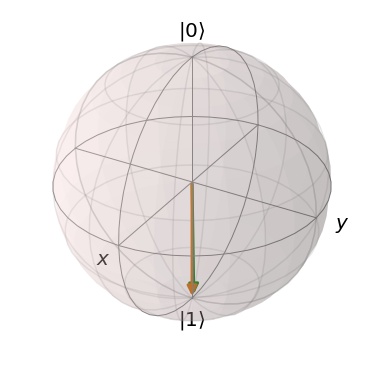

In [17]:
# Create a Bloch sphere
b = Bloch()
b.add_states(qubit_state)
b.add_states(target_state)
b.show()

## Plot the energy level population

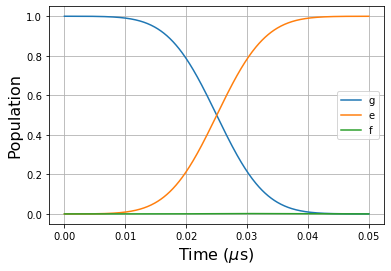

In [18]:
exp_g = expect(fock_dm(N,0),rho)
exp_e = expect(fock_dm(N,1),rho)
exp_f = expect(fock_dm(N,2),rho)

fig, ax = plt.subplots()
ax.plot(tlist, exp_g, label='g')
ax.plot(tlist, exp_e, label='e')
ax.plot(tlist, exp_f, label='f')
plt.xlabel('Time ($\mu$s)',fontsize=16)
plt.ylabel('Population',fontsize=16)

ax.legend()
ax.grid()

## Plot the shape of the pulse

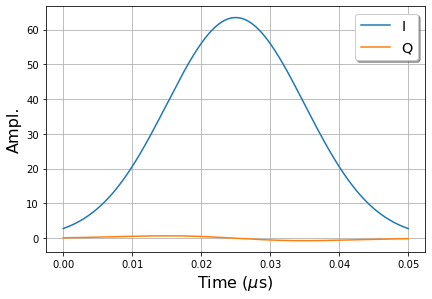

In [19]:
# in-phase component
I = H_drive_coeff_x(tlist, args)
# out of-phase component
Q = H_drive_coeff_y(tlist, args)

fig, ax = plt.subplots()
plt.tight_layout()
ax.plot(tlist, I, label='I')
ax.plot(tlist, Q, label='Q')

plt.xlabel('Time ($\mu$s)',fontsize=16)
plt.ylabel('Ampl.',fontsize=16)

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

ax.grid()

## Plot the state evolution on the Bloch sphere

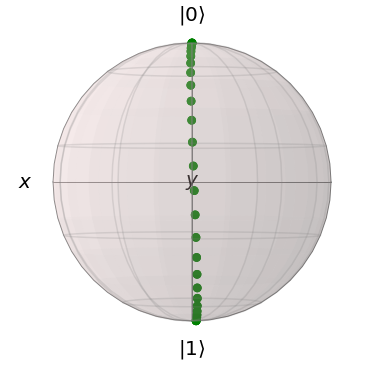

In [20]:
states = result.states
m = len(states) # number of time steps

rotate_U = Qobj([[1,0,0],
                 [0,np.exp(1j*(omega-rotating_frame)*t_total),0],
                 [0,0,np.exp(1j*(omega+alpha-rotating_frame)*t_total)]])

# rotate_U = (1j*a.dag()*a*(omega-rotating_frame)).expm()

# rotated transmon states 
rotated_states = [rotate_U*states[i] for i in range(m)]

# project onto qubit subspace
qubit_states = [(basis(2,0)*basis(3,0).dag() + basis(2,1)*basis(3,1).dag())*rotated_states[i] for i in range(m)]
qubit_states = [qubit_states[i] / qubit_states[i].norm() for i in range(m)]

# Create a Bloch sphere
b = Bloch()
b.view = [0,0]
b.add_states(qubit_states[0::15],'point')
b.point_marker = ['o']
b.point_size = [60]
b.vector_color = ['g']
b.point_color = ['g']
b.show()

## Make Animation

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '360x360', '-pix_fmt', 'rgba', '-r', '100', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'pi-pulse.mp4']' returned non-zero exit status 255.

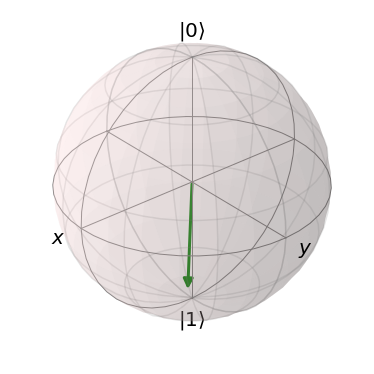

<Figure size 360x360 with 0 Axes>

In [12]:
fig = figure(figsize=(5, 5))
ax = Axes3D(fig,azim=-40,elev=30)
sphere = Bloch(axes=ax)

def animate(i):
    sphere.clear()
    sphere.add_states(qubit_states[i])
    sphere.make_sphere()
    return ax

def init():
    sphere.vector_color = ['g'] 
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(qubit_states)), init_func=init, repeat=False)
ani.save('pi-pulse.mp4', fps=100)

In [21]:
import qutip.ipynbtools
qutip.ipynbtools.version_table()

Software,Version
QuTiP,4.4.1
Numpy,1.17.3
SciPy,1.3.2
matplotlib,3.1.2
Cython,0.29.14
Number of CPUs,6
BLAS Info,Generic
IPython,7.10.1
Python,"3.7.3 | packaged by conda-forge | (default, Jul 1 2019, 14:38:56) [Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
